In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense,Dropout,Input,ZeroPadding2D,Conv2D,Flatten,BatchNormalization,MaxPool2D
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam,SGD
from tensorflow.keras.utils import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from IPython.display import display, Image
from keras import optimizers
import sys

In [2]:
labels_df = pd.read_csv('labels.csv')

In [3]:
print(f' The shape of the labels:{labels_df.shape}')

 The shape of the labels:(10222, 2)


In [4]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
# path of the dogs images
img_file="train/"

In [6]:
#Adding path of the dog image to its id and breed

train_df=labels_df.assign(img_path=lambda x: img_file + x['id'] +'.jpg')
train_df.head()

,id,breed,img_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


### Visualization

dingo


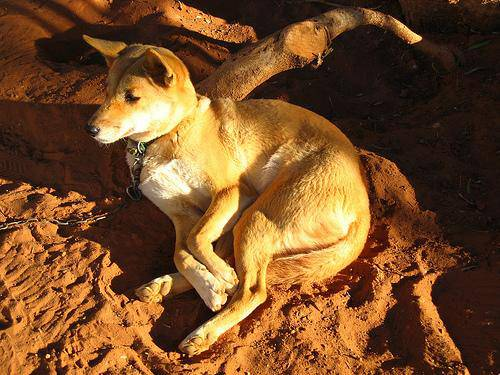

In [7]:
# Viewing an image using filename
print(train_df['breed'][1])
Image(train_df['img_path'][1])

african_hunting_dog


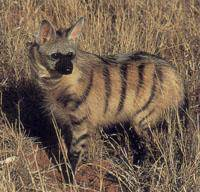

In [8]:
# Viewing an image using filename
print(train_df['breed'][15])
Image(train_df['img_path'][15])

In [9]:
# Visualize the number of each breeds
breeds_all = train_df["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [10]:
# Selecting first 3 breeds (Limitation due to computation power)
CLASS_NAMES = ['scottish_deerhound','maltese_dog','afghan_hound']
labels = train_df[(train_df['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed,img_path
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,train/0042188c895a2f14ef64a918ed9c7b64.jpg
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog,train/00693b8bc2470375cc744a6391d397ec.jpg
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound,train/01e787576c003930f96c966f9c3e1d44.jpg
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog,train/022b34fd8734b39995a9f38a4f3e7b6b.jpg
4,146,0379145880ad3978f9b80f0dc2c03fba,afghan_hound,train/0379145880ad3978f9b80f0dc2c03fba.jpg


We will work on only 3 breeds due to limited computational power

In [11]:
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
# Creating numpy matrix with zeros
X  = np.zeros((len(labels), 224, 224, 3), dtype='float32')

In [12]:
# One hot encoding
y = label_binarize(labels['breed'], classes = CLASS_NAMES)

In [13]:
# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
    img = image.load_img('train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X[i] = x / 255.0

100%|███████████████████████████████████████████████████████████████████████████████| 359/359 [00:01<00:00, 339.52it/s]


In [14]:
# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X.shape,' size: {:,}'.format(X.size))
print('One-hot encoded output shape: ',y.shape,' size: {:,}'.format(y.size))


Train Images shape:  (359, 224, 224, 3)  size: 54,039,552
One-hot encoded output shape:  (359, 3)  size: 1,077


In [15]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)       0

In [16]:
from sklearn.model_selection import train_test_split
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X, y, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [18]:
# Training the model
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val))

Epoch 1/100
3/3 [==============================] - 35s 9s/step - loss: 4.5844 - accuracy: 0.4264 - val_loss: 4.5769 - val_accuracy: 0.4462
Epoch 2/100
3/3 [==============================] - 28s 8s/step - loss: 4.5560 - accuracy: 0.4341 - val_loss: 4.5513 - val_accuracy: 0.4308
Epoch 3/100
3/3 [==============================] - 26s 7s/step - loss: 4.5270 - accuracy: 0.4380 - val_loss: 4.5258 - val_accuracy: 0.2923
Epoch 4/100
3/3 [==============================] - 27s 7s/step - loss: 4.4979 - accuracy: 0.3915 - val_loss: 4.5026 - val_accuracy: 0.2615
Epoch 5/100
3/3 [==============================] - 25s 7s/step - loss: 4.4692 - accuracy: 0.3798 - val_loss: 4.4792 - val_accuracy: 0.2615
Epoch 6/100
3/3 [==============================] - 25s 7s/step - loss: 4.4420 - accuracy: 0.3798 - val_loss: 4.4559 - val_accuracy: 0.2923
Epoch 7/100
3/3 [==============================] - 24s 6s/step - loss: 4.4157 - accuracy: 0.3953 - val_loss: 4.4364 - val_accuracy: 0.2923
Epoch 8/100
3/3 [==========

3/3 [==============================] - 22s 6s/step - loss: 3.2194 - accuracy: 0.6395 - val_loss: 3.3255 - val_accuracy: 0.4923
Epoch 60/100
3/3 [==============================] - 23s 6s/step - loss: 3.2032 - accuracy: 0.6240 - val_loss: 3.2910 - val_accuracy: 0.5538
Epoch 61/100
3/3 [==============================] - 24s 6s/step - loss: 3.1811 - accuracy: 0.6202 - val_loss: 3.2300 - val_accuracy: 0.5385
Epoch 62/100
3/3 [==============================] - 22s 6s/step - loss: 3.1391 - accuracy: 0.6667 - val_loss: 3.1508 - val_accuracy: 0.5385
Epoch 63/100
3/3 [==============================] - 24s 6s/step - loss: 3.1109 - accuracy: 0.6822 - val_loss: 3.1611 - val_accuracy: 0.5385
Epoch 64/100
3/3 [==============================] - 23s 6s/step - loss: 3.1353 - accuracy: 0.5891 - val_loss: 3.1716 - val_accuracy: 0.5231
Epoch 65/100
3/3 [==============================] - 24s 6s/step - loss: 3.0781 - accuracy: 0.6357 - val_loss: 3.0716 - val_accuracy: 0.6154
Epoch 66/100
3/3 [===============